In [95]:
import math
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Lab 01 - MATH/PHYS 241

Dice are commonly used as a means of introducing random outcomes in games. If we have a fair six-sided die, we are equally likely to see a 1, 2, 3, 4, 5, or 6 for any given roll.

If we were to roll the dice many many many times and produce a histogram of the observed rolls, we would expect to see a plot that resembles the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution).

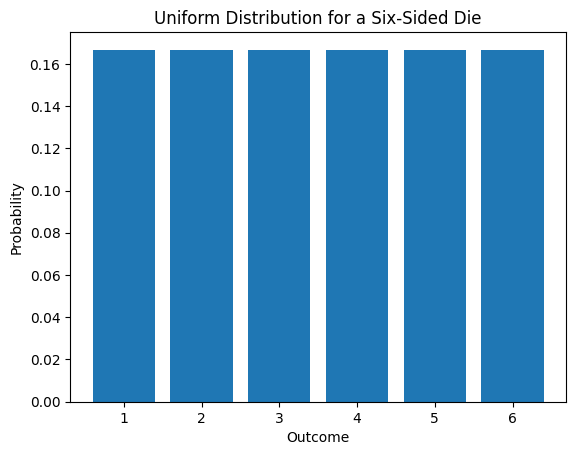

In [96]:
# Define the possible outcomes and their probabilities
outcomes = np.arange(1, 7)  # Outcomes from 1 to 6
probabilities = np.ones(6) / 6  # Equal probability for each outcome

# Create the plot
plt.bar(outcomes, probabilities)
plt.xlabel("Outcome")
plt.ylabel("Probability")
plt.title("Uniform Distribution for a Six-Sided Die")
plt.xticks(outcomes)  # Set x-axis ticks to show all outcomes
plt.show()

Assuming a fair die, it makes sense that as the number of rolls increases, we would expect the distrubiton to more closely match a uniform distribution.

If we were to only roll the die 30 times, the distribution could look very different from uniform. Does that mean the die is biased? How many rolls do we need to "be sure" that the die is fair?

We are now in a position to ask the question of the day:
- How confident are we that an observed outcome matches an expected distribution?

Or, if we state the question a bit differently:
- What is the probability an observed outcome came from a particular distribution?

# Chi Squared ($\chi^2$) Statistic

The chi squared ($\chi^2$) statistic (sometimes referred to as a test statistic) is a measure of how well observed data matches a particular model or distribution. There is a [formal definition](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Derivation) and derivation of why/how it can be used, but we will primarily use it as a measure of [goodness of fit](https://en.wikipedia.org/wiki/Goodness_of_fit).

$\chi^2$ is given as the sum of squared differences between observed and expected outcomes divided by the expected:

$$
\begin{align}
\chi^2 &= \sum^{n}_{i=1} \frac{(O_i - E_i)^2}{E_i} \tag{1}
\end{align}
$$

Where:


*   $E_i$ is the model estimate (expected value)
*   $O_i$ is the observed value


The resulting value can be compared to a chi-square distribution to determine the goodness of fit.


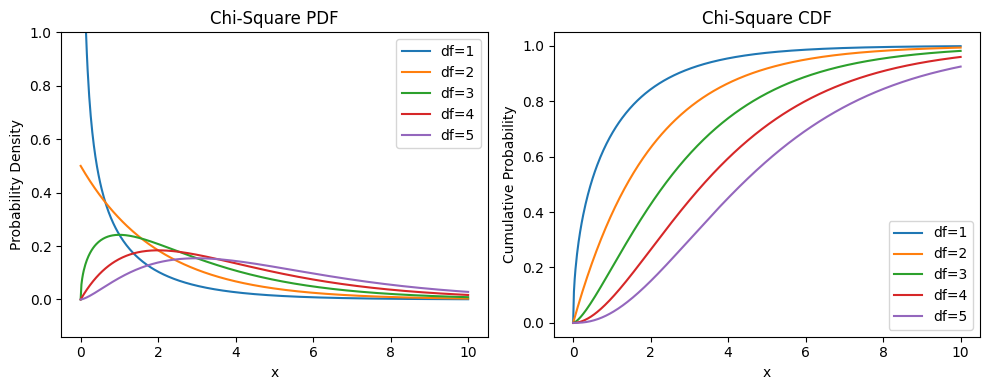

In [97]:
# Define the degrees of freedom
dfs = range(1, 6)

# Define the x-axis range
x = np.linspace(0, 10, 500)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the probability density function on the first subplot
for df in dfs:
    y_pdf = stats.chi2.pdf(x, df)
    ax1.plot(x, y_pdf, label=f"df={df}")

ax1.set_xlabel("x")
ax1.set_ylabel("Probability Density")
ax1.set_title("Chi-Square PDF")
ax1.legend()
ax1.set_ylim(top=1)  # Set the y-axis limit

# Plot the cumulative distribution function on the second subplot
for df in dfs:
    y_cdf = stats.chi2.cdf(x, df)
    ax2.plot(x, y_cdf, label=f"df={df}")

ax2.set_xlabel("x")
ax2.set_ylabel("Cumulative Probability")
ax2.set_title("Chi-Square CDF")
ax2.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

The above plots show the $\chi^2$ probability density function (left) and cumulative distribution function (right).

From the probability density function, we can see the location of the "hump" of the probability density shifts to the right as we increase the degrees of freedom. Here, degrees of freedom is referring to possible outcomes minus 1.

For example, if we had a coin, there are two possible outcomes (heads or tails), so the degrees of freedom would be 1.

Let's work through a quick example to see how we can apply the $\chi^2$ statistic.

# Flipping a Coin

Instead of manually flipping a coin and recording the outcome, we can generate a set of random coin flips by creating a function to flip a coin and record the outcome for us.

In [98]:
def simulate_coin_flips(N):
    """
    Simulates a specified number of coin flips and creates a pandas DataFrame.

    Args:
        N: The number of coin flips to simulate.

    Returns:
        A pandas DataFrame with columns 'coin outcome', 'observed', and 'expected'.
    """

    # Generate coin flip outcomes
    outcomes = np.random.choice(['H', 'T'], size=N)

    # Create DataFrame
    df = pd.DataFrame({
        'coin outcome': ['H', 'T'],
        'observed': [np.sum(outcomes == 'H'), np.sum(outcomes == 'T')],
        'expected': [N / 2, N / 2]  # Assuming a fair coin
    })

    return df

coin_data = simulate_coin_flips(10)
coin_data

,coin outcome,observed,expected
0,H,3,5.0
1,T,7,5.0


Note: if you get 5/5 as a result, run the cell again. Not because the result is bad, but because a non-even result is more interesting to evaluate.

We can now compute the $\chi^2$ statistic based on the result of our simulated coin flips.

In [99]:
# function to compute chi^2 statistic
def compute_chi2_stat(data):
    return sum((data.observed - data.expected)**2 / data.expected )

In [100]:
chi2_stat = compute_chi2_stat(coin_data)
chi2_stat

1.6

We can now plot the $\chi^2$ statistic on the $\chi^2$ PDF plot to visually see where our statistic falls compared to the distribution.

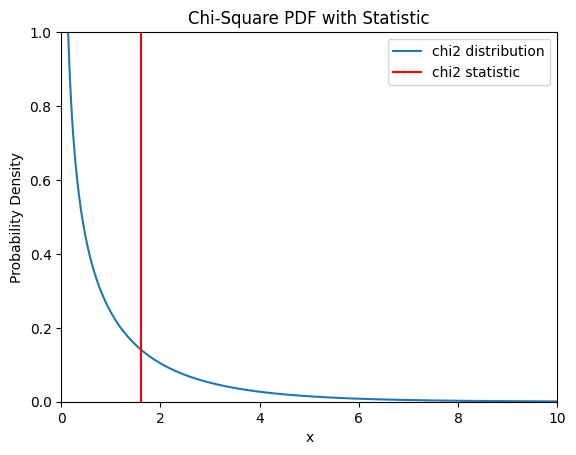

In [101]:
# Define the x-axis range for the PDF plot
x = np.linspace(0, 10, 500)

# Define the degrees of freedom
df = 1

# Plot the chi-square PDF
plt.plot(x, stats.chi2.pdf(x, df), label='chi2 distribution')

# Add the vertical line for the chi-square statistic
plt.axvline(chi2_stat, color='r', label='chi2 statistic')

# Set plot labels and title
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Chi-Square PDF with Statistic")
plt.xlim(0, 10)  # Set the x-axis range
plt.ylim(0, 1)  # Set the y-axis range

# Add a legend
plt.legend()

The plot above can be interpreted in the following manner:

* The area under the curve to the **left** of the vertical line (our test statistic) represents outcomes that are *more* likely to occur.

* The area under the curve to the **right** of the vertical line represents outcomes that are *less* likely to occur.

We can now ask the question: *How unlikely is the outcome we have observed?* The answer to which requires us to compare our result against the null hypothesis.

**Under the null hypothesis (that our coin is fair), how *unlikely* is the $\chi^2$ statistic we observe?**

To test the null hypothesis, we need a threshold to compare against. If we go above this threshold, then we can say the observation is too unlikely to support the claim the coin is fair.

In general, we typically use 95% as a confidence bounds, meaning as long as the test statistic is under this threshold, we accept the null hypothesis. The exact percent chosen is arbitrary, there is no universally accepted confidence bounds across all of science, but 95% is often the number reported.

Whatever confidnce bounds chosen, the value is often referred to as the *critical value*. If you look up [listed critical values](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3674.htm) of the $\chi^2$ distribution, you will typically see 90%, 95%, 97.5%, 99%, and 99.9% values for different degrees of freedom.

To find the critical value using python, we can use: `stats.chi2.ppf(confidence, degrees of freedom)`



In [102]:
# set confidence boundary
confidence = 0.95

# calculate critical value
z95 = stats.chi2.ppf(confidence, df)

# note, if you choose 90%, call CV z90
z95

np.float64(3.841458820694124)

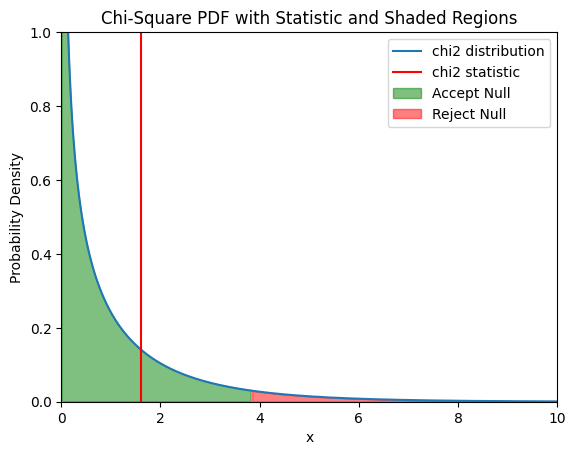

In [103]:
x = np.linspace(0, 10, 500)  # x-axis range

# Plot the chi-square PDF
plt.plot(x, stats.chi2.pdf(x, df), label='chi2 distribution')

# Add the vertical line for the chi-square statistic
plt.axvline(chi2_stat, color='r', label='chi2 statistic')

# Shade the regions
plt.fill_between(x, 0, stats.chi2.pdf(x, df),
                 where=(x <= z95),
                 color='green',
                 alpha=0.5,
                 label='Accept Null')

plt.fill_between(x, 0, stats.chi2.pdf(x, df),
                 where=(x > z95),
                 color='red',
                 alpha=0.5,
                 label='Reject Null')

# Set plot labels and title
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Chi-Square PDF with Statistic and Shaded Regions")
plt.xlim(0, 10)  # Set the x-axis range
plt.ylim(0, 1)  # Set the y-axis range

# Add a legend
plt.legend()

# Show the plot
plt.show()

The plot above clearly indicates where our test statistic falls, visually telling us our observed outcome either does or does not reject the null hypothesis.

# Experiment: Rolling Dice

In this lab, we have two dice. You are tasked with answering the following:

* Are both dice fair?

To answer this, roll each die 150 times each. Record the outcome of each roll in an excel or sheets file and save the file as a csv. Import your data files to the notebook and perform the statistical tests to verify the fairness of each die. Discuss and defend your results.